In [2]:
%matplotlib inline
import os, struct
from array import array as pyarray
import numpy as np
from scipy.cluster.vq import *
from numpy import append, array, int8, uint8, zeros
from pylab import *
from numpy import *
import matplotlib
import matplotlib.pyplot as plt

In [3]:
from scipy.spatial import distance

class Data(object):
    # N points, k cluster, p dimensions
    def __init__(self, N, k, p):
        self.N = N
        self.k = k
        self.p = p
        self.true_center = []
        self.true_cluster_list = []
        self.data_set = []
        self.PIs = []
        self.means = []
        self.sigma = 0.0

    def init_board_gauss(self):
        n = float(self.N)/self.k
        X = []
        for i in range(self.k):
            c = ()
            # construct a random center point
            for j in range(self.p):
                c = c + (random.uniform(-1,1),)
            self.true_center.append(c)
            #s = random.uniform(0.05,0.5)
            s = 0.05
            x = []
            while len(x) < n:
                # need to change dimension
                lst = []
                for i in c:
                    lst.append(np.random.normal(i,s))
                point = np.array(lst)
                good = True
                for i in point:
                    if abs(i) >= 1:
                        good = False
                if good:
                    x.append(point)
            X.extend(x)
        X = np.array(X)[:self.N]
        return X

    def set_data(self, data):
        self.data_set = data
    # Taking in true center list, and the result center list
    def error_calculate(self,res):
        error = 0.0
        for i in range(self.k):
            min_dis = distance.euclidean(self.true_center[i],res[0])
            for j in range(self.k):
                # calculate the distance btw true center and kmean center
                dst = distance.euclidean(self.true_center[i],res[j])
                # find the minimum dst btw the true center and kmean center
                if dst < min_dis:
                    min_dis = dst
            error += min_dis * min_dis
        # print "the error rate is: ", error
        return math.sqrt(error / (self.sigma * self.sigma * self.p))

    # calculate the true function enables more kmean center than true center
    # this is for the true center 
    def true_cost_function(self):
        cost = 0.0
        # loop through the data set
        for data in self.data_set:
            # min_dist is the distance to the first true center
            min_dis = distance.euclidean(data,self.true_center[0])
            # loop through the true center
            for i in range(self.k):
                 # calculate the distance btw true center and kmean center
                dst = distance.euclidean(data,self.true_center[i])
                # find the minimum dst btw the true center and kmean center
                if dst < min_dis:
                    min_dis = dst
            cost += min_dis * min_dis
        return cost
    
    # this is for the cost function compared to the true center cost function
    def cost_function(self,res):
        cost = 0.0
        # loop through the whole dataset
        for data in self.data_set:
            min_dis = distance.euclidean(data,res[0])
            for i in range(len(res)):
                 # calculate the distance btw true center and kmean center
                dst = distance.euclidean(data,res[i])
                # find the minimum dst btw the true center and kmean center
                if dst < min_dis:
                    min_dis = dst
            cost += min_dis * min_dis
        # the ratio of result center cost/ true center cost
        return cost/self.true_cost_function()
            

    def set_true_center(self, means):
        self.true_center = means
        
        #print "true center is ", self.true_center


    # mean is a p dimensional vector, covarience is a p*p matrix
    # number_of_sample is n samples
    # return value: n*p matrix, generate n samples from N(mean,covarience)
    def generate_mult_normal_data(self, mean, covariance, num_of_samples):
        return np.random.multivariate_normal(mean,covariance, num_of_samples)

    # prob is list of probability that sums to 1
    # means is a p dimensional vector,covarience is a p*p matrix
    # number_of_samples is n samples
    # return value: generate n samples from the mixture of Gaussian
    def generate_mult_normal_based_prob(self, prob, means, covariance, num_of_samples):
        data_list = []
        # keep track which points belong to which cluster
        true_cluster_list = []
        for i in range(num_of_samples):
            # flip a coin to see which cluster the data point comes from
            random_num = random.random()
            sum = 0.0
            index = -1
            for p in prob:
                if random_num < sum:
                    break
                sum += p
                index = index + 1
            true_cluster_list.append(index)
            # call the generate_mult_normal_data rountine
            data_list.append(self.generate_mult_normal_data(means[index], covariance,1)[0])
        self.true_cluster_list = true_cluster_list
        return np.array(data_list)[:num_of_samples]
        #return (np.array(data_list)[:num_of_samples], true_cluster_list)
    def generate_data(self, dimension, p_sigma, number_of_cluster, number_of_points):
        # dimension
        self.p = dimension

        # sqrt of variance
        self.sigma = p_sigma

        # k is number of clusters
        self.k = number_of_cluster

        # n is number of points to be generated
        self.N = number_of_points

        # init a covariance matrix as identity matrix
        self.identity_matrix = np.identity(self.p)

        # covariance matrix
        covariance = self.sigma * self.sigma * self.identity_matrix
        # choose means from


        # means are from a normal distribution with center is all 0s and varience N(0,sigma squre identity matrix)
        mean = []
        for i in range(self.p):
            mean.append(0)
        # choose means, k is the number of centers/cluster
        self.means = self.generate_mult_normal_data(mean, covariance, self.k)

        self.set_true_center(self.means)

        # choose pis, ASA probabolity
        self.PIs = []
        for i in range(self.k):
            # every cluster has the same probability
            self.PIs.append(1.0/self.k)

        # generate n points from the mixture model
        self.data_set = self.generate_mult_normal_based_prob(self.PIs, self.means, covariance, self.N)

In [4]:
from sklearn.datasets import fetch_mldata
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
import matplotlib
import pylab
import matplotlib.pyplot as plt 
mnist = fetch_mldata('MNIST original', data_home='./data')
print "finish fetching data"
X_digits, _,_, Y_digits = mnist.values() # fetch dataset from internet
images0 = []
images1 = []
images2 = []
images3 = []
images4 = []
images5 = []
images6 = []
images7 = []
images8 = []
images9 = []
for i in range(len(Y_digits)):
    if Y_digits[i] == 0.0:
        images0.append(X_digits[i])
    elif Y_digits[i] == 1.0:
        images1.append(X_digits[i])
    elif Y_digits[i] == 2.0:
        images2.append(X_digits[i])
    elif Y_digits[i] == 3.0:
        images3.append(X_digits[i])
    elif Y_digits[i] == 4.0:
        images4.append(X_digits[i])
    elif Y_digits[i] == 5.0:
        images5.append(X_digits[i])
    elif Y_digits[i] == 6.0:
        images6.append(X_digits[i])
    elif Y_digits[i] == 7.0:
        images7.append(X_digits[i])
    elif Y_digits[i] == 8.0:
        images8.append(X_digits[i])
    elif Y_digits[i] == 9.0:
        images9.append(X_digits[i])
mnist_true_center1 = []
mnist_true_center = []
mnist_true_center.append(np.array(images0).mean(axis=0).reshape(28,28))
mnist_true_center.append(np.array(images1).mean(axis=0).reshape(28,28))
mnist_true_center.append(np.array(images2).mean(axis=0).reshape(28,28))
mnist_true_center.append(np.array(images3).mean(axis=0).reshape(28,28))
mnist_true_center.append(np.array(images4).mean(axis=0).reshape(28,28))
mnist_true_center.append(np.array(images5).mean(axis=0).reshape(28,28))
mnist_true_center.append(np.array(images6).mean(axis=0).reshape(28,28))
mnist_true_center.append(np.array(images7).mean(axis=0).reshape(28,28))
mnist_true_center.append(np.array(images8).mean(axis=0).reshape(28,28))
mnist_true_center.append(np.array(images9).mean(axis=0).reshape(28,28))

mnist_true_center1.append(np.array(images0).mean(axis=0))
mnist_true_center1.append(np.array(images1).mean(axis=0))
mnist_true_center1.append(np.array(images2).mean(axis=0))
mnist_true_center1.append(np.array(images3).mean(axis=0))
mnist_true_center1.append(np.array(images4).mean(axis=0))
mnist_true_center1.append(np.array(images5).mean(axis=0))
mnist_true_center1.append(np.array(images6).mean(axis=0))
mnist_true_center1.append(np.array(images7).mean(axis=0))
mnist_true_center1.append(np.array(images8).mean(axis=0))
mnist_true_center1.append(np.array(images9).mean(axis=0))


# imshow(mnist_true_center[0], cmap=cm.gray)
# show()
# imshow(mnist_true_center[1], cmap=cm.gray)
# show()
# imshow(mnist_true_center[2], cmap=cm.gray)
# show()
# imshow(mnist_true_center[3], cmap=cm.gray)
# show()
# imshow(mnist_true_center[4], cmap=cm.gray)
# show()
# imshow(mnist_true_center[5], cmap=cm.gray)
# show()
# imshow(mnist_true_center[6], cmap=cm.gray)
# show()
# imshow(mnist_true_center[7], cmap=cm.gray)
# show()
# imshow(mnist_true_center[8], cmap=cm.gray)
# show()
# imshow(mnist_true_center[9], cmap=cm.gray)
# show()

#X_digits, Y_digits = shuffle(X_digits,Y_digits) # shuffle dataset (which is     ordered!)
X_digits = X_digits[-5000:]
Y_digits = Y_digits[-5000:]
# plt.rc("image", cmap="binary") # use black/white palette for plotting
# for i in xrange(15):
#     plt.subplot(3,5,i+1)
#     plt.imshow(X_digits[10+i].reshape(28,28))
#     plt.xticks(())
#     plt.yticks(())
# plt.show()

# # classify to 10 clusters
# kmeans = KMeans(10)
# mu_digits = kmeans.fit(X_digits).cluster_centers_

# plt.figure(figsize=(16,6))
# for i in xrange(2*(mu_digits.shape[0]/2)): # loop over all means
#     plt.subplot(2,mu_digits.shape[0]/2,i+1)
#     plt.imshow(mu_digits[i].reshape(28,28))
#     plt.xticks(())
#     plt.yticks(())
# plt.show()



finish fetching data


Digit 0, true center: 


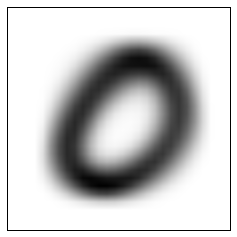

Digit 0, closest to center: 


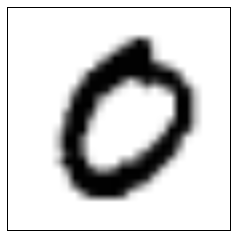

Digit 0, farthest to center: 


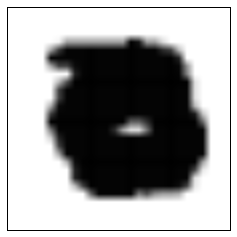

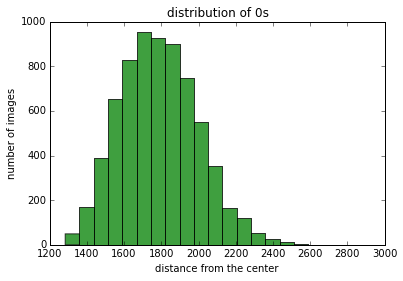

In [5]:
from scipy.spatial import distance
plt.rc("image", cmap="binary")
print "Digit 0, true center: "
# Display distribution of data from the center
plt.imshow(mnist_true_center1[0].reshape(28,28))
plt.xticks(())
plt.yticks(())
plt.show()
results = []

# what we consider as the best teaching signals
min_images = []
# What we consider as the worst teaching signals
max_images = []
for image in images0:
    results.append(distance.euclidean(image, mnist_true_center1[0]))
minIndex = results.index(min(results))

print "Digit 0, closest to center: "
plt.imshow(images0[minIndex].reshape(28,28))
plt.xticks(())
plt.yticks(())
plt.show()
print "Digit 0, farthest to center: "
maxIndex = results.index(max(results))
plt.imshow(images0[maxIndex].reshape(28,28))
plt.xticks(())
plt.yticks(())
plt.show()
plt.xlabel("distance from the center")
plt.ylabel("number of images")
plt.title("distribution of 0s")
n, bins, patches = plt.hist(results,20, normed = 0, facecolor="green", alpha=0.75)
plt.show()
min_images.append(images0[minIndex])
max_images.append(images0[maxIndex])

Digit 1, true center: 


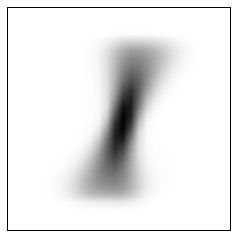

Digit 1, closest to center: 


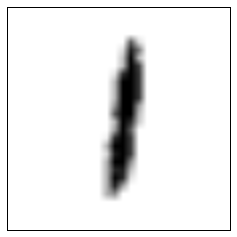

Digit 1, farthest to center: 


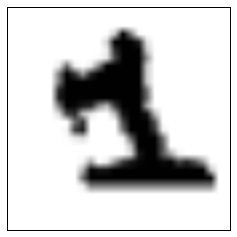

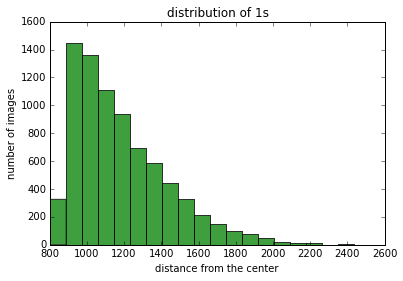

In [6]:


# Display distribution of data from the center
results = []
print "Digit 1, true center: "
plt.imshow(mnist_true_center1[1].reshape(28,28))
plt.xticks(())
plt.yticks(())
plt.show()
for image in images1:
    results.append(distance.euclidean(image, mnist_true_center1[1]))
minIndex = results.index(min(results))
plt.rc("image", cmap="binary")
print "Digit 1, closest to center: "
plt.imshow(images1[minIndex].reshape(28,28))
plt.xticks(())
plt.yticks(())
plt.show()
maxIndex = results.index(max(results))
print "Digit 1, farthest to center: "
plt.imshow(images1[maxIndex].reshape(28,28))
plt.xticks(())
plt.yticks(())
plt.show()
plt.xlabel("distance from the center")
plt.ylabel("number of images")
plt.title("distribution of 1s")
n, bins, patches = plt.hist(results,20, normed = 0, facecolor="green", alpha=0.75)
plt.show()
min_images.append(images1[minIndex])
max_images.append(images1[maxIndex])

Digit 2, true center: 


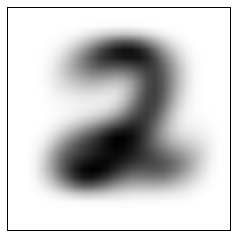

Digit 2, closest to center: 


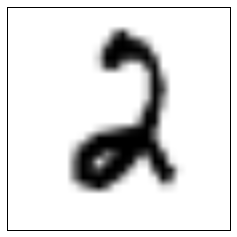

Digit 2, farthest to center: 


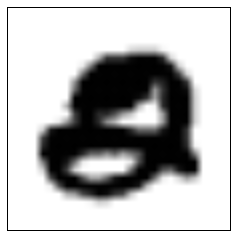

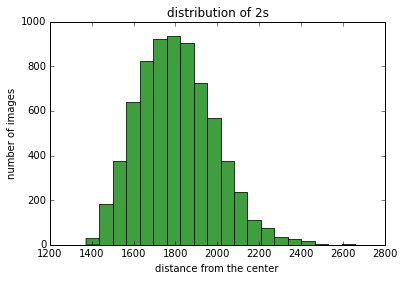

In [7]:
# Display distribution of data from the center
results = []
print "Digit 2, true center: "

plt.imshow(mnist_true_center1[2].reshape(28,28))
plt.xticks(())
plt.yticks(())
plt.show()
for image in images2:
    results.append(distance.euclidean(image, mnist_true_center1[2]))
minIndex = results.index(min(results))
plt.rc("image", cmap="binary")
print "Digit 2, closest to center: "

plt.imshow(images2[minIndex].reshape(28,28))
plt.xticks(())
plt.yticks(())
plt.show()
maxIndex = results.index(max(results))
print "Digit 2, farthest to center: "

plt.imshow(images2[maxIndex].reshape(28,28))
plt.xticks(())
plt.yticks(())
plt.show()
plt.xlabel("distance from the center")
plt.ylabel("number of images")
plt.title("distribution of 2s")
n, bins, patches = plt.hist(results,20, normed = 0, facecolor="green", alpha=0.75)
plt.show()
min_images.append(images2[minIndex])
max_images.append(images2[maxIndex])

Digit 3, true center: 


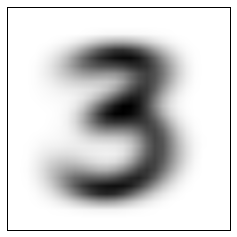

Digit 3, closest to center: 


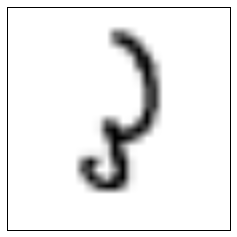

Digit 3, farthest to center: 


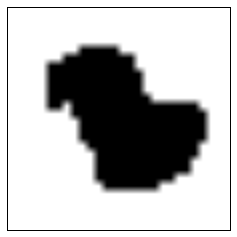

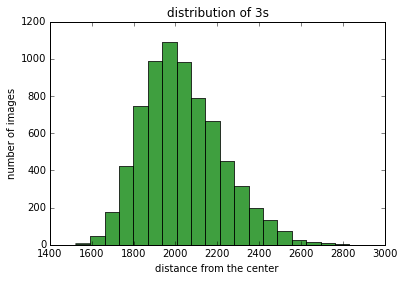

In [8]:
# Display distribution of data from the center
results = []
print "Digit 3, true center: "

plt.imshow(mnist_true_center1[3].reshape(28,28))
plt.xticks(())
plt.yticks(())
plt.show()
for image in images3:
    results.append(distance.euclidean(image, mnist_true_center1[2]))
minIndex = results.index(min(results))
plt.rc("image", cmap="binary")
print "Digit 3, closest to center: "

plt.imshow(images3[minIndex].reshape(28,28))
plt.xticks(())
plt.yticks(())
plt.show()
maxIndex = results.index(max(results))
print "Digit 3, farthest to center: "

plt.imshow(images3[maxIndex].reshape(28,28))
plt.xticks(())
plt.yticks(())
plt.show()
plt.xlabel("distance from the center")
plt.ylabel("number of images")
plt.title("distribution of 3s")
n, bins, patches = plt.hist(results,20, normed = 0, facecolor="green", alpha=0.75)
plt.show()
min_images.append(images3[minIndex])
max_images.append(images3[maxIndex])

Digit 4, true center: 


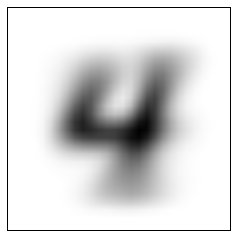

Digit 4, closest to center: 


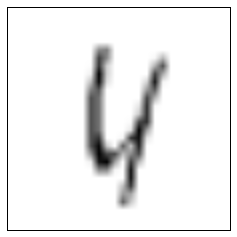

Digit 4, farthest to center: 


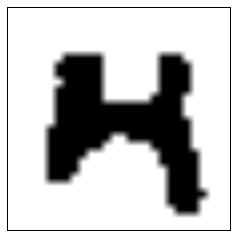

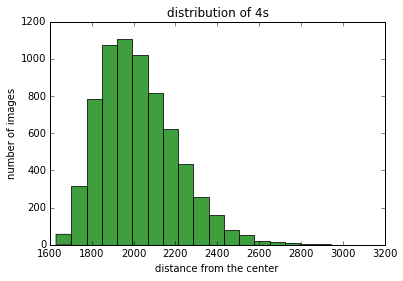

In [9]:
# Display distribution of data from the center
results = []
print "Digit 4, true center: "

plt.imshow(mnist_true_center1[4].reshape(28,28))
plt.xticks(())
plt.yticks(())
plt.show()
for image in images4:
    results.append(distance.euclidean(image, mnist_true_center1[2]))
minIndex = results.index(min(results))
plt.rc("image", cmap="binary")
print "Digit 4, closest to center: "

plt.imshow(images4[minIndex].reshape(28,28))
plt.xticks(())
plt.yticks(())
plt.show()
maxIndex = results.index(max(results))
print "Digit 4, farthest to center: "
plt.imshow(images4[maxIndex].reshape(28,28))
plt.xticks(())
plt.yticks(())
plt.show()
plt.xlabel("distance from the center")
plt.ylabel("number of images")
plt.title("distribution of 4s")
n, bins, patches = plt.hist(results,20, normed = 0, facecolor="green", alpha=0.75)
plt.show()
min_images.append(images4[minIndex])
max_images.append(images4[maxIndex])

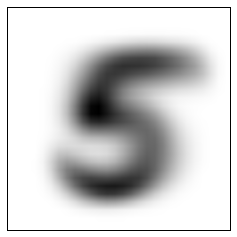

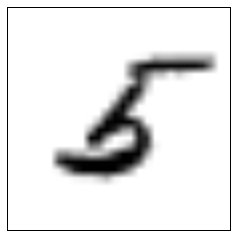

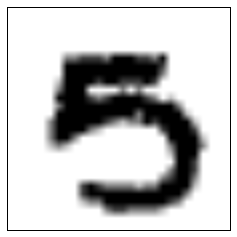

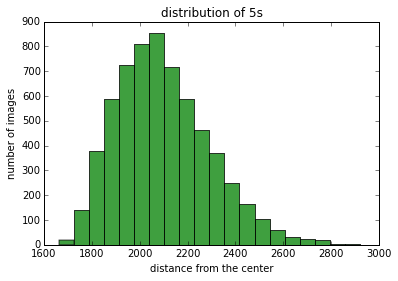

In [10]:
# Display distribution of data from the center
results = []
plt.imshow(mnist_true_center1[5].reshape(28,28))
plt.xticks(())
plt.yticks(())
plt.show()
for image in images5:
    results.append(distance.euclidean(image, mnist_true_center1[2]))
minIndex = results.index(min(results))
plt.rc("image", cmap="binary")
plt.imshow(images5[minIndex].reshape(28,28))
plt.xticks(())
plt.yticks(())
plt.show()
maxIndex = results.index(max(results))
plt.imshow(images5[maxIndex].reshape(28,28))
plt.xticks(())
plt.yticks(())
plt.show()
plt.xlabel("distance from the center")
plt.ylabel("number of images")
plt.title("distribution of 5s")
n, bins, patches = plt.hist(results,20, normed = 0, facecolor="green", alpha=0.75)
plt.show()
min_images.append(images5[minIndex])
max_images.append(images5[maxIndex])

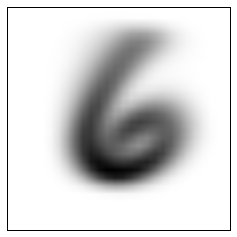

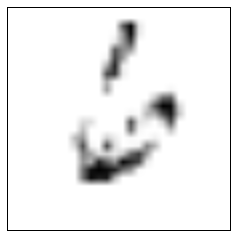

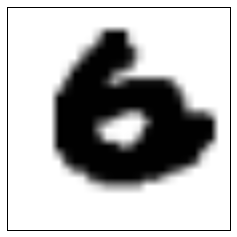

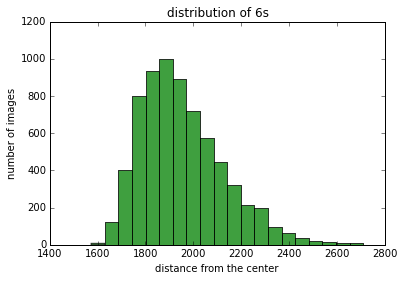

In [11]:
# Display distribution of data from the center
results = []
plt.imshow(mnist_true_center1[6].reshape(28,28))
plt.xticks(())
plt.yticks(())
plt.show()
for image in images6:
    results.append(distance.euclidean(image, mnist_true_center1[2]))
minIndex = results.index(min(results))
plt.rc("image", cmap="binary")
plt.imshow(images6[minIndex].reshape(28,28))
plt.xticks(())
plt.yticks(())
plt.show()
maxIndex = results.index(max(results))
plt.imshow(images6[maxIndex].reshape(28,28))
plt.xticks(())
plt.yticks(())
plt.show()
plt.xlabel("distance from the center")
plt.ylabel("number of images")
plt.title("distribution of 6s")
n, bins, patches = plt.hist(results,20, normed = 0, facecolor="green", alpha=0.75)
plt.show()
min_images.append(images6[minIndex])
max_images.append(images6[maxIndex])

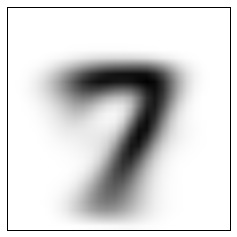

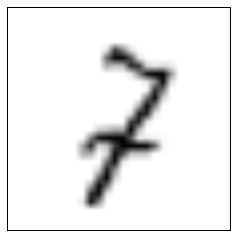

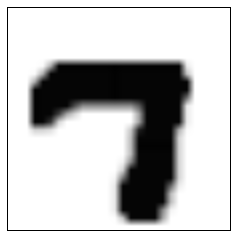

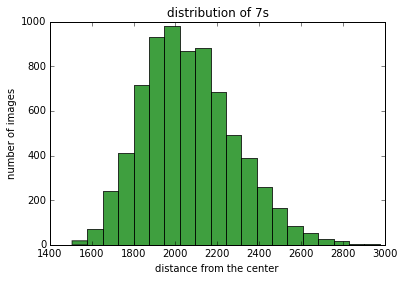

In [12]:
# Display distribution of data from the center
results = []
plt.imshow(mnist_true_center1[7].reshape(28,28))
plt.xticks(())
plt.yticks(())
plt.show()
for image in images7:
    results.append(distance.euclidean(image, mnist_true_center1[2]))
minIndex = results.index(min(results))
plt.rc("image", cmap="binary")
plt.imshow(images7[minIndex].reshape(28,28))
plt.xticks(())
plt.yticks(())
plt.show()
maxIndex = results.index(max(results))
plt.imshow(images7[maxIndex].reshape(28,28))
plt.xticks(())
plt.yticks(())
plt.show()
plt.xlabel("distance from the center")
plt.ylabel("number of images")
plt.title("distribution of 7s")
n, bins, patches = plt.hist(results,20, normed = 0, facecolor="green", alpha=0.75)
plt.show()
min_images.append(images7[minIndex])
max_images.append(images7[maxIndex])

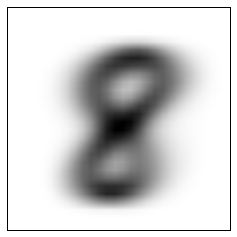

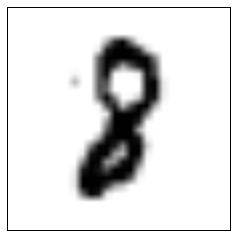

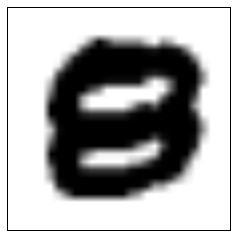

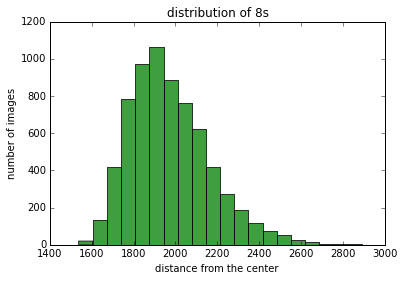

In [13]:
# Display distribution of data from the center
results = []
plt.imshow(mnist_true_center1[8].reshape(28,28))
plt.xticks(())
plt.yticks(())
plt.show()
for image in images8:
    results.append(distance.euclidean(image, mnist_true_center1[2]))
minIndex = results.index(min(results))
plt.rc("image", cmap="binary")
plt.imshow(images8[minIndex].reshape(28,28))
plt.xticks(())
plt.yticks(())
plt.show()
maxIndex = results.index(max(results))
plt.imshow(images8[maxIndex].reshape(28,28))
plt.xticks(())
plt.yticks(())
plt.show()
plt.xlabel("distance from the center")
plt.ylabel("number of images")
plt.title("distribution of 8s")
n, bins, patches = plt.hist(results,20, normed = 0, facecolor="green", alpha=0.75)
plt.show()
min_images.append(images8[minIndex])
max_images.append(images8[maxIndex])

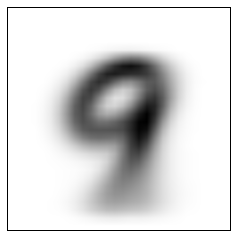

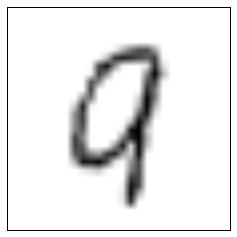

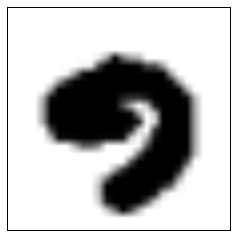

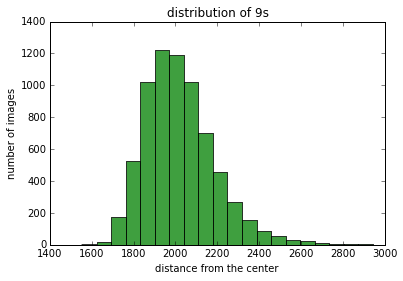

In [14]:
# Display distribution of data from the center
results = []
plt.imshow(mnist_true_center1[9].reshape(28,28))
plt.xticks(())
plt.yticks(())
plt.show()
for image in images9:
    results.append(distance.euclidean(image, mnist_true_center1[2]))
minIndex = results.index(min(results))
plt.rc("image", cmap="binary")
plt.imshow(images9[minIndex].reshape(28,28))
plt.xticks(())
plt.yticks(())
plt.show()
maxIndex = results.index(max(results))
plt.imshow(images9[maxIndex].reshape(28,28))
plt.xticks(())
plt.yticks(())
plt.show()
plt.xlabel("distance from the center")
plt.ylabel("number of images")
plt.title("distribution of 9s")
n, bins, patches = plt.hist(results,20, normed = 0, facecolor="green", alpha=0.75)
plt.show()
min_images.append(images9[minIndex])
max_images.append(images9[maxIndex])

In [15]:
# Testing to run sequential k mean
def sequential_kmean(data, k):
    kmean_center = []
    # idx store the cluster number the corresponding data point refer to
    idx = []
    for i in range(0, len(data)):
        idx.append(0)
    # set count n1 ... nk to 1
    counts = []
    for i in range(k):
        counts.append(1)

    # set the first seen k points to the kmean center
    for i in range(k):
        kmean_center.append(data[i])
        idx[i] = i   # remember which cluster
    kmean_center_np = np.array(kmean_center)
    index = k
    # look at the next point, and do one pass through the dataset
    while index < len(data):
        # print index
        current_point = data[index]
        min_dist =  distance.euclidean(kmean_center_np[0], current_point)
        replace_position = 0

        # find the distance to the nearest kmean center
        for i in range(k):
            dist = distance.euclidean(kmean_center_np[i], current_point)
            if dist <= min_dist:
                min_dist = dist
                replace_position = i
        # index is the current point
        idx[index] = replace_position
        index = index + 1
        # update the kmean center accordingly
        kmean_center_np[replace_position] = ((counts[replace_position] * kmean_center_np[replace_position]) + current_point) / (counts[replace_position] + 1.0)
        # update the countes -> increase the weights
        counts[replace_position] = counts[replace_position] + 1
    return np.array(kmean_center), np.array(idx)


In [16]:
X_digits,_,_,Y_digits = mnist.values()

In [17]:
import random
pairs = zip(X_digits, Y_digits)
random.shuffle(pairs)

5000


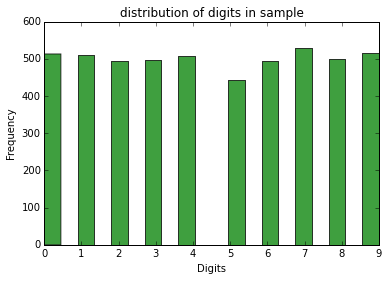

5000
256
256
256
256
263
256
256
257
285
2659


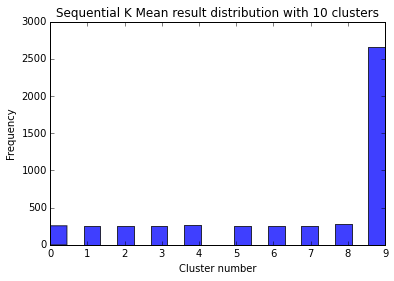

Cost:  8.46015650105e-06


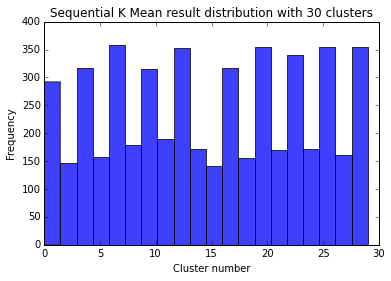

Cost:  2.82520307628e-06


In [22]:
pair = pairs[:5000]
print len(pair)
X = [i[0] for i in pair]
Y = [i[1] for i in pair]
plt.xlabel("Digits")
plt.ylabel("Frequency")
plt.title("distribution of digits in sample")
n, bins, patches = plt.hist(Y ,20, normed = 0, facecolor="green", alpha=0.75)
plt.show()
#print ref_d
res, idx = sequential_kmean(X, 10)
error = 0
print len(idx)
for i in range(0, 10):
    print idx.tolist().count(i)
plt.xlabel("Cluster number")
plt.ylabel("Frequency")
plt.title("Sequential K Mean result distribution with 10 clusters")
n, bins, patches = plt.hist(idx ,20, normed = 0, facecolor="blue", alpha=0.75)
plt.show()
# Data has actually 10 clusters
d3 = Data(len(X), 10, len(X[0]))
d3.set_data(X)
d3.set_true_center(mnist_true_center1)
d = {'0':[], '1':[], '2':[], '3':[], '4':[], '5':[], '6':[], '7':[], '8':[], '9':[]}
#print d['0']
for i in range(0, 5000):
    if Y[i] == 0.0:
        d['0'].append(idx[i])
    elif Y[i] == 1.0:
        d['1'].append(idx[i])
    elif Y[i] == 2.0:
        d['2'].append(idx[i])
    elif Y[i] == 3.0:
        d['3'].append(idx[i])
    elif Y[i] == 4.0:
        d['4'].append(idx[i])
    elif Y[i] == 5.0:
        d['5'].append(idx[i])
    elif Y[i] == 6.0:
        d['6'].append(idx[i])
    elif Y[i] == 7.0:
        d['7'].append(idx[i])
    elif Y[i] == 8.0:
        d['8'].append(idx[i])
    elif Y[i] == 9.0:
        d['9'].append(idx[i])

# for key in d:
#     print d[key]
cost_function_score = []
# Display the center choose by our sequential k mean
# for i in res:
#     plt.imshow(i.reshape(28,28))
#     plt.xticks(())
#     plt.yticks(())
#     plt.show()
cost_function_score.append(d3.cost_function(res))
print "Cost: ", cost_function_score[0]

res, idx = sequential_kmean(X, 30)
error = 0
plt.xlabel("Cluster number")
plt.ylabel("Frequency")
plt.title("Sequential K Mean result distribution with 30 clusters")
n, bins, patches = plt.hist(idx ,20, normed = 0, facecolor="blue", alpha=0.75)
plt.show()

cost_function_score = []
cost_function_score.append(d3.cost_function(res))
print "Cost: ", cost_function_score[0]



Giving 10 teaching signal


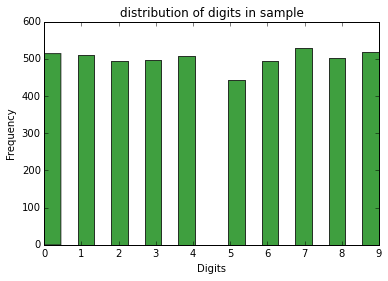

406
710
463
611
461
512
398
463
336
650


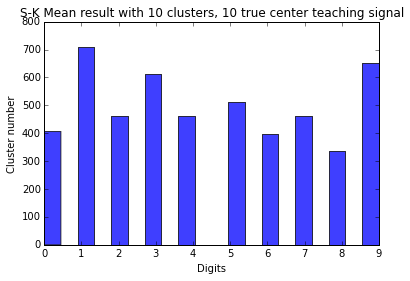

In [23]:
# This set of experiment proves that provide the true center as teaching signal improves the 
# classification significantly
pair = pairs[:5000]
print "Giving 10 teaching signal"
lst = []
for i in range(0, 10):
    lst.append([mnist_true_center1[i%10], i])
pair = lst + pair
X = [i[0] for i in pair]
Y = [i[1] for i in pair]
plt.xlabel("Digits")
plt.ylabel("Frequency")
plt.title("distribution of digits in sample")
n, bins, patches = plt.hist(Y ,20, normed = 0, facecolor="green", alpha=0.75)
plt.show()
res, idx = sequential_kmean(X, 10)
for i in range(0, 10):
    print idx.tolist().count(i)
plt.xlabel("Digits")
plt.ylabel("Cluster number")
plt.title("S-K Mean result with 10 clusters, 10 true center teaching signal")
n, bins, patches = plt.hist(idx ,20, normed = 0, facecolor="blue", alpha=0.75)
plt.show()
    

Apply teaching signal that are farthest to true center


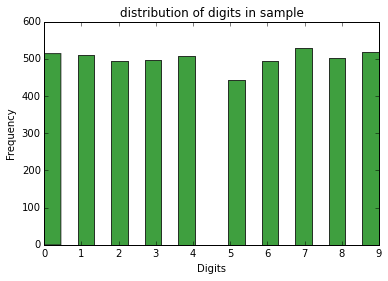

256
256
256
256
256
256
256
256
255
2707


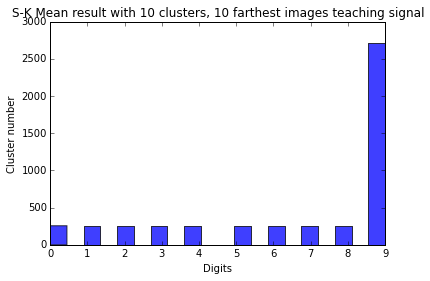

8.65519217038e-06
Apply teaching signal that are closest to true center
255
256
256
256
256
254
254
256
282
2685


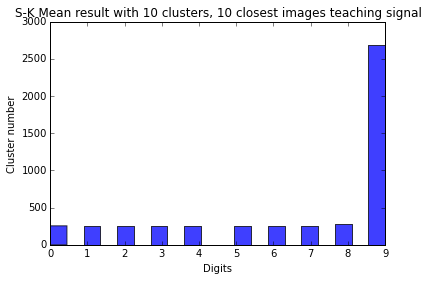

8.61013366761e-06


In [24]:
pair = pairs[:5000]
# Apply some typical examples
print "Apply teaching signal that are farthest to true center"
lst = []
for i in range(0, 10):
    lst.append([max_images[i], i])
pair = lst + pair

X = [i[0] for i in pair]
Y = [i[1] for i in pair]

d4 = Data(len(X), 10, len(X[0]))
d4.set_data(X)
d4.set_true_center(mnist_true_center1)

plt.xlabel("Digits")
plt.ylabel("Frequency")
plt.title("distribution of digits in sample")
n, bins, patches = plt.hist(Y ,20, normed = 0, facecolor="green", alpha=0.75)
plt.show()
res, idx = sequential_kmean(X, 10)
for i in range(0, 10):
    print idx.tolist().count(i)
plt.xlabel("Digits")
plt.ylabel("Cluster number")
plt.title("S-K Mean result with 10 clusters, 10 farthest images teaching signal")
n, bins, patches = plt.hist(idx ,20, normed = 0, facecolor="blue", alpha=0.75)
plt.show()
print d4.cost_function(res)

pair = pairs[:5000]

print "Apply teaching signal that are closest to true center"    
lst = []
for i in range(0, 10):
    lst.append([min_images[i], i])
pair = lst + pair
X = [i[0] for i in pair]
Y = [i[1] for i in pair]
d5 = Data(len(X), 10, len(X[0]))
d5.set_data(X)
d5.set_true_center(mnist_true_center1)

res, idx = sequential_kmean(X, 10)
for i in range(0, 10):
    print idx.tolist().count(i)
plt.xlabel("Digits")
plt.ylabel("Cluster number")
plt.title("S-K Mean result with 10 clusters, 10 closest images teaching signal")
n, bins, patches = plt.hist(idx ,20, normed = 0, facecolor="blue", alpha=0.75)
plt.show()
print d5.cost_function(res)

In [21]:
print "number of data is ", len(X_digits)
print "each points is in dimension ", len(X_digits[0])
d2 = Data(len(X_digits), 10, len(X_digits[0]))
d2.set_data(X_digits)
d2.set_true_center(mnist_true_center1)
# run 5 times
cost_function_score = []
for i in range (0,5):
    # classify to 10 clusters
    kmeans = KMeans(10)
    mu_digits = kmeans.fit(X_digits).cluster_centers_
    cost_function_score.append(d2.cost_function(mu_digits))
print cost_function_score
# plot the histogram for the score
plt.xlabel('Cost function results')
plt.ylabel('Frequency of the cost function result')
plt.title(r'Histogram of Kmean on MNIST dataset for 10 clusters')
n, bins, patches = plt.hist(cost_function_score,20,normed=0,facecolor="Red",alpha=0.75)
plt.show()

#print d2.cost_function(mu_digits)

number of data is  70000
each points is in dimension  784


KeyboardInterrupt: 

In [ ]:
#cluster MNIST to 15 clusters
# run 5 times
cost_function_score = []
for i in range (0,5):
    # classify to 10 clusters
    kmeans = KMeans(15)
    mu_digits = kmeans.fit(X_digits).cluster_centers_
    cost_function_score.append(d2.cost_function(mu_digits))
print cost_function_score
# plot the histogram for the score
plt.xlabel('Cost function results')
plt.ylabel('Frequency of the cost function result')
plt.title(r'Histogram of Kmean on MNIST dataset for 15 clusters')
n, bins, patches = plt.hist(cost_function_score,20,normed=0,facecolor="Red",alpha=0.75)
plt.show()



In [ ]:
#cluster MNIST to 30 clusters
# run 5 times
cost_function_score = []
for i in range (0,5):
    # classify to 10 clusters
    kmeans = KMeans(30)
    mu_digits = kmeans.fit(X_digits).cluster_centers_
    cost_function_score.append(d2.cost_function(mu_digits))
print cost_function_score
# plot the histogram for the score
plt.xlabel('Cost function results')
plt.ylabel('Frequency of the cost function result')
plt.title(r'Histogram of Kmean on MNIST dataset for 15 clusters')
n, bins, patches = plt.hist(cost_function_score,20,normed=0,facecolor="Red",alpha=0.75)
plt.show()